In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\data\items.csv
.\data\items_new.csv
.\data\item_categories.csv
.\data\item_categories_new.csv
.\data\model_pca.pkl
.\data\sales_train.csv
.\data\sales_train_ag_m.csv
.\data\sales_train_new.csv
.\data\sample_submission.csv
.\data\shops.csv
.\data\shops_new.csv
.\data\test.csv
.\data\test_new.csv
.\data\X_sparse_test.pkl
.\data\X_sparse_train.pkl
.\data\y_train.pkl


In [4]:
sales_train_ag_m = pd.read_csv('.\data\sales_train_ag_m.csv', index_col=0)
test_new = pd.read_csv('.\data\\test_new.csv', index_col=0)     

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
sales_train_ag_m.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price,item_category_id,glob_item_category,city
0,0,2,27,1,2013,1.0,2499.0,19,Игры,Адыгея
42141,0,42,21553,1,2013,1.0,199.0,40,Кино,СПб
42142,0,42,21554,1,2013,1.0,199.0,40,Кино,СПб
42143,0,42,21565,1,2013,3.0,349.0,55,Музыка,СПб
42144,0,42,21571,1,2013,1.0,199.0,55,Музыка,СПб


# Нейроные сети

## 1) Рекуррентная нейронная сеть, обученная на продажах в предыдущем месяце

В предыдущем примере мы видели, что продажи в будущем месяце хорошо предсказываются данными прошлых месяцев, построим базовую рекуррентую нейроную сеть, обученную на продажах за предыдущие месяцы

In [7]:
sales_agg = sales_train_ag_m.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_month', fill_value=0).reset_index()
sales_agg.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0


In [13]:
test_agg = pd.merge(test_new, sales_agg, on=['item_id', 'shop_id'], how='left')
test_agg = test_agg.fillna(0)
test_agg.head()

,shop_id,item_id,month,year,item_category_id,glob_item_category,city,0,1,2,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,11,2015,19,Игры,Вологда,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,11,2015,55,Музыка,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,11,2015,19,Игры,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,11,2015,23,Игры,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,11,2015,20,Игры,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
test_agg.drop(['shop_id','item_id','month','year','item_category_id','glob_item_category','city'],axis=1, inplace=True)

In [15]:
X_train = np.expand_dims(test_agg.values[:, :-1], axis=2)
y_train = test_agg.values[:, -1:]

X_test = np.expand_dims(test_agg.values[:, 1:], axis=2)
print(X_train.shape, y_train.shape, X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(33, 1))) #рекурентный слой
model.add(Dropout(0.3)) 
model.add(Dense(1)) # нет функции активации т.к. решаем задачу регрессии

model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, batch_size=4096, epochs=10)

Train on 214200 samples
Epoch 1/10
214200/214200 [==============================] - 77s 360us/sample - loss: 1.5181 - mean_squared_error: 1.5181
Epoch 2/10
214200/214200 [==============================] - 72s 334us/sample - loss: 1.3350 - mean_squared_error: 1.3350
Epoch 3/10
214200/214200 [==============================] - 68s 317us/sample - loss: 1.2743 - mean_squared_error: 1.2743
Epoch 4/10
214200/214200 [==============================] - 69s 321us/sample - loss: 1.2426 - mean_squared_error: 1.2426
Epoch 5/10
214200/214200 [==============================] - 70s 326us/sample - loss: 1.2248 - mean_squared_error: 1.2248
Epoch 6/10
214200/214200 [==============================] - 70s 326us/sample - loss: 1.2121 - mean_squared_error: 1.2121
Epoch 7/10
214200/214200 [==============================] - 70s 329us/sample - loss: 1.2037 - mean_squared_error: 1.2037
Epoch 8/10
214200/214200 [==============================] - 70s 329us/sample - loss: 1.1918 - mean_squared_error: 1.1918
Epoch 9/

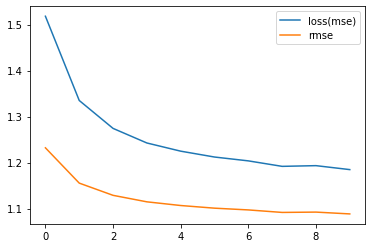

In [19]:
plt.plot(history.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(history.history['mean_squared_error']), label= 'rmse')
plt.legend(loc=1)

In [20]:
LSTM_prediction = model.predict(X_test)

In [24]:
test = pd.read_csv('.\data\\test.csv')

In [26]:
submission_lstm = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': LSTM_prediction.ravel()})
submission_lstm.to_csv('submission_lstm.csv',index=False) # оценка 1.02537 (наблюдаем улчучшение по сравнению с базовой моделью)

In [28]:
submission_lstm.head()

,ID,item_cnt_month
0,0,0.533477
1,1,0.126397
2,2,0.802080
3,3,0.177636
4,4,0.126397


In [33]:
submission_lstm['item_cnt_month'] = submission_lstm['item_cnt_month'].apply(lambda x: round(x))

In [34]:
submission_lstm.head()

,ID,item_cnt_month
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


In [39]:
submission_lstm = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': list(map(round,LSTM_prediction.ravel()))})
submission_lstm.to_csv('submission_lstm_2.csv',index=False) # оценка 1.04 ухудшилась, округление не нужно

## 2) Рекуррентная нейронная сеть, обученная на продажах в предыдущем месяце и дополнительных признаках

In [41]:
test_agg = pd.merge(test_new, sales_agg, on=['item_id', 'shop_id'], how='left')
test_agg = test_agg.fillna(0)
test_agg.head()

,shop_id,item_id,month,year,item_category_id,glob_item_category,city,0,1,2,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,11,2015,19,Игры,Вологда,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,11,2015,55,Музыка,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,11,2015,19,Игры,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,11,2015,23,Игры,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,11,2015,20,Игры,Вологда,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
test_agg.drop(['shop_id','item_id','month','year','item_category_id'],axis=1, inplace=True)

In [44]:
test_agg.head()

,glob_item_category,city,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,Игры,Вологда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,Музыка,Вологда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Игры,Вологда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,Игры,Вологда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Игры,Вологда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Закодируем признаки glob_item_category, city one-hot методом

In [46]:
from sklearn.preprocessing import OneHotEncoder
enc_glob_item_category = OneHotEncoder(handle_unknown='ignore')
enc_glob_item_category = enc_glob_item_category.fit(test_agg['glob_item_category'].values.reshape(-1, 1))

In [47]:
enc_city = OneHotEncoder(handle_unknown='ignore')
enc_city = enc_city.fit(test_agg['city'].values.reshape(-1, 1))

In [48]:
test_agg_d = test_agg.drop(['glob_item_category','city'], axis=1)

In [49]:
test_agg_d.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
test_agg_train = test_agg_d.values[:,:-1]
test_agg_test = test_agg_d.values[:,1:]
y_train = test_agg_d.values[:,-1:]

In [52]:
city_one_hot = enc_city.transform(test_agg['city'].values.reshape(-1, 1))
glob_item_category_one_hot = enc_glob_item_category.transform(test_agg['glob_item_category'].values.reshape(-1, 1))

In [65]:
from scipy.sparse import hstack
X_train = hstack([city_one_hot, glob_item_category_one_hot, test_agg_train])
X_test = hstack([city_one_hot, glob_item_category_one_hot, test_agg_test])

In [66]:
X_train = X_train.tocsc()
X_train.toarray()
X_train = np.expand_dims(X_train.toarray(), axis=2)
X_train.shape

(214200, 74, 1)

In [67]:
X_test = X_test.tocsc()
X_test.toarray()
X_test = np.expand_dims(X_test.toarray(), axis=2)
X_test.shape

(214200, 74, 1)

In [68]:
model = Sequential()
model.add(LSTM(units=74, input_shape=(74, 1))) #рекурентный слой
model.add(Dropout(0.3)) 
model.add(Dense(1)) # нет функции активации т.к. решаем задачу регрессии

model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 74)                22496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 74)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 75        
Total params: 22,571
Trainable params: 22,571
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(X_train, y_train, batch_size=4096, epochs=10)

Train on 214200 samples
Epoch 1/10
214200/214200 [==============================] - 311s 1ms/sample - loss: 1.4379 - mean_squared_error: 1.4379
Epoch 2/10
214200/214200 [==============================] - 190s 887us/sample - loss: 1.2817 - mean_squared_error: 1.2817
Epoch 3/10
214200/214200 [==============================] - 188s 876us/sample - loss: 1.2367 - mean_squared_error: 1.2367
Epoch 4/10
214200/214200 [==============================] - 192s 895us/sample - loss: 1.2135 - mean_squared_error: 1.2135
Epoch 5/10
214200/214200 [==============================] - 189s 883us/sample - loss: 1.2032 - mean_squared_error: 1.2032
Epoch 6/10
214200/214200 [==============================] - 188s 877us/sample - loss: 1.1927 - mean_squared_error: 1.1927
Epoch 7/10
214200/214200 [==============================] - 183s 854us/sample - loss: 1.1899 - mean_squared_error: 1.1899
Epoch 8/10
214200/214200 [==============================] - 178s 829us/sample - loss: 1.1811 - mean_squared_error: 1.1811
Ep

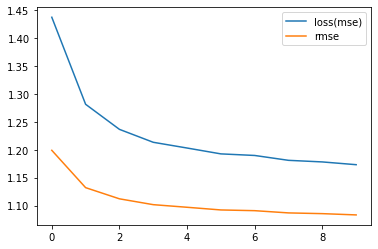

In [70]:
plt.plot(history.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(history.history['mean_squared_error']), label= 'rmse')
plt.legend(loc=1)

In [71]:
LSTM_prediction_d = model.predict(X_test)

In [72]:
submission_lstm_d = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': LSTM_prediction_d.ravel()})
submission_lstm_d.to_csv('submission_lstm_3.csv',index=False) 

In [73]:
submission_lstm_d.head()

,ID,item_cnt_month
0,0,0.475805
1,1,0.118509
2,2,0.810728
3,3,0.173556
4,4,0.120083


In [74]:
submission_lstm_d['item_cnt_month'].apply(lambda x: round(x)).value_counts()

0     196398
1      13676
2       2121
3        800
4        360
5        216
6        170
7        115
8         74
9         51
17        41
10        38
11        34
12        31
16        25
15        19
14        15
13        14
18         2
Name: item_cnt_month, dtype: int64